In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns


In [59]:
_parent_folder = "single_cam_dec_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\single_cam_dec_14'

In [60]:
"""path based on text file"""
data_pth_file = open(os.path.join(os.path.dirname(os.getcwd()), "src", "data_path.txt"), "r+")
_base_pth = data_pth_file.read()
_base_pth = os.path.join(_base_pth, _parent_folder)

In [65]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files_corrected.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk18_15_forward_fast,calibration_15fps_00,False
1,sk18_15_forward_fast_2,calibration_15fps_00,False
2,sk18_15_forward_medium,calibration_15fps_00,False
3,sk18_15_forward_medium_2,calibration_15fps_00,False
4,sk18_15_forward_slow,calibration_15fps_00,False
...,...,...,...
92,sk19_30_sideways_fast_2,calibration_30fps_00_2nd_take,False
93,sk19_30_random_fast,calibration_30fps_00_2nd_take,False
94,sk19_30_random_fast_2,calibration_30fps_00_2nd_take,False
95,sk19_30_quad_fast,calibration_30fps_00_2nd_take,False


In [66]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [67]:
mean_err_df = pd.DataFrame(columns=["folder_name","date_created" ,"frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z",
                                     "offset_x", "offset_y", "offset_z"])

In [68]:
for idx, _folder_name in enumerate(tqdm(folder_df.folder_name)):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_webcam_wot_4cm_corrected", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc_4cm_corrected", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _mc_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)


    _w_df = transform_coordinates_1(_phone_cam_df, _webcam_rot, _webcam_org)
    _w_df.time = pd.to_datetime(_w_df.time)
    _mc_df.time = pd.to_datetime(_mc_df.time)

    # find the offset
    _offset_x = _w_df.x.iloc[0] - _mc_df.x.iloc[0]
    _offset_y = _w_df.y.iloc[0] - _mc_df.y.iloc[0]
    _offset_z = _w_df.z.iloc[0] - _mc_df.z.iloc[0]

    _mc_df.x = _mc_df.x + _offset_x
    _mc_df.y = _mc_df.y + _offset_y
    _mc_df.z = _mc_df.z + _offset_z


    # filter the data
    _w_df.x = savgol_filter(_w_df.x, 51, 1)
    _w_df.y = savgol_filter(_w_df.y, 51, 1)
    _w_df.z = savgol_filter(_w_df.z, 51, 1)
    
    error_df = pd.DataFrame()
    error_df["time"] = _mc_df["time"]
    error_df["x"] = _mc_df["x"] - _w_df["x"]
    error_df["y"] = _mc_df["y"] - _w_df["y"]
    error_df["z"] = _mc_df["z"] - _w_df["z"]
    error_df["frame_id"] = _w_df["frame_id"]

    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx],"date_created": None, "frame_id":  error_df["frame_id"][0],
                                    "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean(), 
                                    "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), "max_err_z": error_df["z"].max(), 
                                    "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(), "std_err_z": error_df["z"].std(),
                                    "offset_x": _offset_x, "offset_y": _offset_y, "offset_z": _offset_z}, ignore_index=True)

    

100%|██████████| 97/97 [16:19<00:00, 10.10s/it]


In [69]:
# save the mean error
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_filter_4cm_corrected.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)

# read the mean error df
mean_err_df = pd.read_csv(os.path.join(_analysis_pth, "mean_error_df_filter_4cm_corrected.csv"))
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,offset_x,offset_y,offset_z
0,sk18_15_forward_fast,NaN,5.0,0.000505,0.001488,0.005592,0.008367,0.008178,0.070711,0.002731,0.002286,0.024829,-0.008169,0.002813,-0.044837
1,sk18_15_forward_fast_2,NaN,5.0,-0.001250,0.000016,-0.005754,0.008238,0.006669,0.038290,0.002498,0.001819,0.021290,-0.011120,0.001302,-0.060686
2,sk18_15_forward_medium,NaN,5.0,-0.000995,-0.006162,-0.030770,0.007513,-0.001582,0.012527,0.002878,0.001881,0.023114,-0.009395,-0.004638,-0.080513
3,sk18_15_forward_medium_2,NaN,5.0,0.000700,0.006341,0.025962,0.007747,0.011974,0.069863,0.002493,0.002495,0.021570,-0.008565,0.007940,-0.025627
4,sk18_15_forward_slow,NaN,5.0,-0.001297,0.000510,-0.004194,0.007815,0.005573,0.029458,0.002689,0.001865,0.017859,-0.009803,0.001938,-0.056291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,sk19_30_sideways_fast_2,NaN,5.0,-0.000157,-0.001392,-0.005771,0.019512,0.004439,0.020680,0.003983,0.001949,0.009208,-0.001101,0.004101,-0.051416
93,sk19_30_random_fast,NaN,5.0,-0.005014,0.004494,0.015973,0.029898,0.011718,0.080541,0.013112,0.003227,0.024900,-0.000946,0.009504,-0.024410
94,sk19_30_random_fast_2,NaN,5.0,-0.003814,0.002558,0.007237,0.023002,0.009085,0.063308,0.011173,0.002082,0.019428,-0.002372,0.007252,-0.037967
95,sk19_30_quad_fast,NaN,9.0,-0.002886,-0.006920,-0.006274,0.003340,0.012925,0.027423,0.005811,0.011510,0.016185,-0.012612,-0.012404,-0.071017


In [70]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

#object of movement
object_values = []
for i in mean_err_df.folder_name:
    _object = i.split("_")[2]
    
    if _object == "quad":
        object_values.append("quad")
    else:
        object_values.append("skateboard")
mean_err_df["object"] = object_values

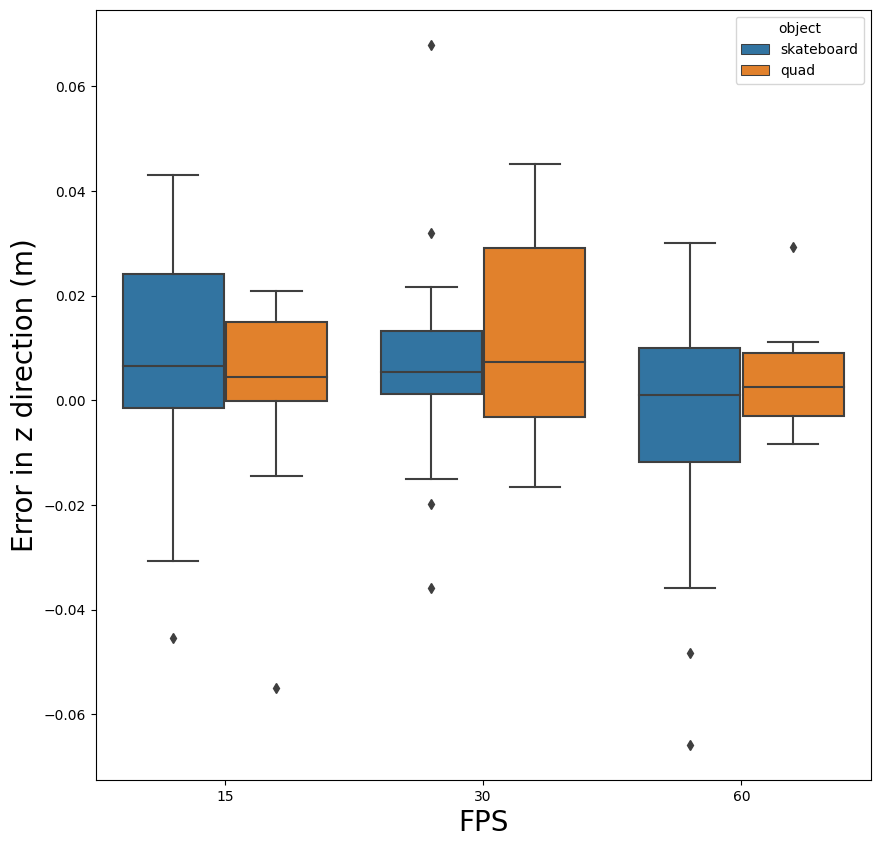

In [78]:
# box plot based on speed
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="fps", y="err_z", hue="object", data=mean_err_df, ax=ax)

# label
ax.set_xlabel("FPS", fontsize=20)
ax.set_ylabel("Error in z direction (m)", fontsize=20)
plt.show()

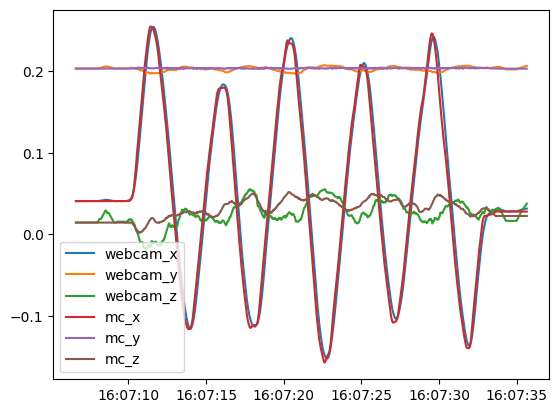

In [ ]:
# plot _w_df and _mc_df
w_df = _w_df.copy(deep=True)

w_df.x = savgol_filter(_w_df.x, 51, 1)
w_df.y = savgol_filter(_w_df.y, 51, 1)
w_df.z = savgol_filter(_w_df.z, 51, 1)
plt.plot(_w_df.time, w_df.x, label="webcam_x")
plt.plot(_w_df.time, w_df.y, label="webcam_y")
plt.plot(_w_df.time, w_df.z, label="webcam_z")
plt.plot(_mc_df.time, _mc_df.x, label="mc_x")
plt.plot(_mc_df.time, _mc_df.y, label="mc_y")
plt.plot(_mc_df.time, _mc_df.z, label="mc_z")


plt.legend()